In [ ]:
#System and Python package setup (Torch + COCO tools)
!apt-get update -qq
!apt-get install -qq git gcc
!pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install pycocotools

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
# Install Detectron2 from source in editable mode
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .

Cloning into 'detectron2'...
remote: Enumerating objects: 15895, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 15895 (delta 58), reused 29 (delta 22), pack-reused 15787 (from 4)
Receiving objects: 100% (15895/15895), 6.44 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (11561/11561), done.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=b1018ff0cd201fa7dc66b359ff9d2ec639ad2b3b330cb43e7a78ada90f717382
  Stored in direct

In [ ]:
# Confirm Detectron2 installation and check CUDA availability
import torch
from detectron2.utils.logger import setup_logger
import detectron2

setup_logger()

print("Detectron2 installed from source successfully!")
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Detectron2 installed from source successfully!
Torch version: 2.7.1+cu118
CUDA available: True


In [ ]:
# Set up Detectron2 configuration and load pretrained Mask R-CNN model
import os
import cv2
import numpy as np
import json

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # ↑ for accuracy
cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)

[07/07 13:04:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 172MB/s]                           


In [ ]:
#Loop through videos and generate polygon annotations for selected object classes
from tqdm import tqdm
import cv2
import numpy as np
import os
import pandas as pd
import json

video_folder = "/content/video_folder"
csv_path = "/content/annotations_master.csv"
target_classes = [0, 1, 2]  #COCO IDs for person, bicycle, car
snapshot_frames = []

# Track already processed videos
processed_videos = set()
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    processed_videos = set(df_existing["video"].unique())
    print(f"Already processed: {len(processed_videos)} videos.")

# Process each video
for vid_name in os.listdir(video_folder):
    if vid_name in processed_videos:
        print(f"Skipping already processed: {vid_name}")
        continue
    video_annotations = []
    video_path = os.path.join(video_folder, vid_name)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num=min(300, total_frames), dtype=int) #300 spaced frames to reduce load
    print(f"🎥 Processing {vid_name} ({total_frames} frames)")

    for frame_num in tqdm(frame_indices, desc=f"⏳ {vid_name}", position=0, leave=True):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret or frame is None:
            continue
        frame = cv2.resize(frame, (720, 405)) #Resizing to reduce computation
        outputs = predictor(frame)
        instances = outputs["instances"].to("cpu")
        masks = instances.pred_masks
        classes = instances.pred_classes
        frame_objects = []
        #Convert segmentation masks to polygons for target object classes
        for i, (mask, cls) in enumerate(zip(masks, classes)):
            if int(cls) not in target_classes:
                continue
            contours, _ = cv2.findContours(mask.numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if len(contour) >= 3:
                    epsilon = 0.01 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)
                    polygon = approx.squeeze().tolist()
                    if isinstance(polygon[0], list):
                        polygon = [pt for pt in polygon]
                    frame_objects.append({
                        "class_id": int(cls),
                        "polygon": polygon
                    })

        #Save annotations if relevant objects found
        if frame_objects:
            video_annotations.append({
                "video": vid_name,
                "frame_index": int(frame_num),
                "objects": frame_objects
            })
            #Randomly store snapshot frames for visual validation
            if len(snapshot_frames) < 15 and np.random.rand() < 0.05:
                snapshot_frames.append((frame.copy(), outputs["instances"].to("cpu"), vid_name, frame_num))

    cap.release()

    #Convert annotation data to rows for saving to CSV
    rows = []
    for entry in video_annotations:
        video = entry["video"]
        frame = entry["frame_index"]
        for obj in entry["objects"]:
            class_id = obj["class_id"]
            polygon = str(obj["polygon"])
            rows.append({
                "video": video,
                "frame_index": frame,
                "class_id": class_id,
                "polygon": polygon
            })

    #Append to existing CSV or create new file
    batch_df = pd.DataFrame(rows)
    if os.path.exists(csv_path):
        batch_df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        batch_df.to_csv(csv_path, index=False)

    print(f"✅ Saved {len(batch_df)} annotations for {vid_name}")

🎥 Processing 029abf56-094a6f08.mp4 (1205 frames)


⏳ 029abf56-094a6f08.mp4:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
⏳ 029abf56-094a6f08.mp4: 100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


✅ Saved 1894 annotations for 029abf56-094a6f08.mp4
🎥 Processing 02a0f142-1b621396.mp4 (1203 frames)


⏳ 02a0f142-1b621396.mp4: 100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


✅ Saved 2421 annotations for 02a0f142-1b621396.mp4
🎥 Processing 029e2aad-f295cf71.mp4 (1204 frames)


⏳ 029e2aad-f295cf71.mp4: 100%|██████████| 300/300 [03:22<00:00,  1.48it/s]


✅ Saved 5251 annotations for 029e2aad-f295cf71.mp4
🎥 Processing 02a26ce5-42f8fd75.mp4 (2398 frames)


⏳ 02a26ce5-42f8fd75.mp4: 100%|██████████| 300/300 [02:56<00:00,  1.70it/s]


✅ Saved 5044 annotations for 02a26ce5-42f8fd75.mp4
🎥 Processing 02a26ce5-597cae3f.mp4 (1203 frames)


⏳ 02a26ce5-597cae3f.mp4: 100%|██████████| 300/300 [03:56<00:00,  1.27it/s]


✅ Saved 4291 annotations for 02a26ce5-597cae3f.mp4
🎥 Processing 02b3f1b2-eb3e84c6.mp4 (2404 frames)


⏳ 02b3f1b2-eb3e84c6.mp4: 100%|██████████| 300/300 [02:55<00:00,  1.71it/s]


✅ Saved 4238 annotations for 02b3f1b2-eb3e84c6.mp4
🎥 Processing 01dd2e02-88356eaa.mp4 (1209 frames)


⏳ 01dd2e02-88356eaa.mp4: 100%|██████████| 300/300 [03:11<00:00,  1.57it/s]


✅ Saved 1284 annotations for 01dd2e02-88356eaa.mp4
🎥 Processing 01853f47-6975b587.mp4 (2402 frames)


⏳ 01853f47-6975b587.mp4: 100%|██████████| 300/300 [02:30<00:00,  1.99it/s]


✅ Saved 2484 annotations for 01853f47-6975b587.mp4
🎥 Processing 029ffd50-dc944dba.mp4 (1212 frames)


⏳ 029ffd50-dc944dba.mp4: 100%|██████████| 300/300 [03:29<00:00,  1.43it/s]


✅ Saved 3023 annotations for 029ffd50-dc944dba.mp4
🎥 Processing 00d9e313-7d75bb18.mp4 (1207 frames)


⏳ 00d9e313-7d75bb18.mp4: 100%|██████████| 300/300 [03:00<00:00,  1.66it/s]


✅ Saved 2364 annotations for 00d9e313-7d75bb18.mp4
🎥 Processing 02a46296-f95ec53f.mp4 (1204 frames)


⏳ 02a46296-f95ec53f.mp4: 100%|██████████| 300/300 [02:51<00:00,  1.75it/s]


✅ Saved 3603 annotations for 02a46296-f95ec53f.mp4
🎥 Processing 02ab2e11-e7054d3c.mp4 (1207 frames)


⏳ 02ab2e11-e7054d3c.mp4: 100%|██████████| 300/300 [02:41<00:00,  1.86it/s]


✅ Saved 1361 annotations for 02ab2e11-e7054d3c.mp4
🎥 Processing 02a11306-ea3764fe.mp4 (2414 frames)


⏳ 02a11306-ea3764fe.mp4: 100%|██████████| 300/300 [02:56<00:00,  1.70it/s]


✅ Saved 3472 annotations for 02a11306-ea3764fe.mp4
🎥 Processing 02a70c1f-6df7ce64.mp4 (1206 frames)


⏳ 02a70c1f-6df7ce64.mp4: 100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


✅ Saved 3199 annotations for 02a70c1f-6df7ce64.mp4
🎥 Processing 01b4e4b9-e21fe0a3.mp4 (2406 frames)


⏳ 01b4e4b9-e21fe0a3.mp4: 100%|██████████| 300/300 [02:49<00:00,  1.77it/s]


✅ Saved 4827 annotations for 01b4e4b9-e21fe0a3.mp4
🎥 Processing 01c71072-718028b8.mp4 (1202 frames)


⏳ 01c71072-718028b8.mp4: 100%|██████████| 300/300 [03:49<00:00,  1.31it/s]


✅ Saved 5352 annotations for 01c71072-718028b8.mp4
🎥 Processing 00c17a92-d4803287.mp4 (1202 frames)


⏳ 00c17a92-d4803287.mp4: 100%|██████████| 300/300 [03:57<00:00,  1.27it/s]


✅ Saved 2199 annotations for 00c17a92-d4803287.mp4
🎥 Processing 00091078-cedbfea7.mp4 (1567 frames)


⏳ 00091078-cedbfea7.mp4: 100%|██████████| 300/300 [02:46<00:00,  1.80it/s]


✅ Saved 1368 annotations for 00091078-cedbfea7.mp4
🎥 Processing 007aeb45-c601742b.mp4 (2522 frames)


⏳ 007aeb45-c601742b.mp4: 100%|██████████| 300/300 [03:10<00:00,  1.58it/s]


✅ Saved 5110 annotations for 007aeb45-c601742b.mp4
🎥 Processing 0048f391-8eb40ca6.mp4 (1210 frames)


⏳ 0048f391-8eb40ca6.mp4: 100%|██████████| 300/300 [03:29<00:00,  1.43it/s]


✅ Saved 2552 annotations for 0048f391-8eb40ca6.mp4
🎥 Processing 00fcfec9-8accd82b.mp4 (1232 frames)


⏳ 00fcfec9-8accd82b.mp4: 100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


✅ Saved 1299 annotations for 00fcfec9-8accd82b.mp4
🎥 Processing 02a7e164-14ba1015.mp4 (1202 frames)


⏳ 02a7e164-14ba1015.mp4: 100%|██████████| 300/300 [02:46<00:00,  1.80it/s]


✅ Saved 2046 annotations for 02a7e164-14ba1015.mp4
🎥 Processing 02b12643-452a1808.mp4 (2411 frames)


⏳ 02b12643-452a1808.mp4: 100%|██████████| 300/300 [02:41<00:00,  1.86it/s]


✅ Saved 5750 annotations for 02b12643-452a1808.mp4
🎥 Processing 029e1042-2639a5f8.mp4 (1203 frames)


⏳ 029e1042-2639a5f8.mp4: 100%|██████████| 300/300 [03:12<00:00,  1.56it/s]


✅ Saved 6363 annotations for 029e1042-2639a5f8.mp4
🎥 Processing 02a54ddc-ed40d4d2.mp4 (1207 frames)


⏳ 02a54ddc-ed40d4d2.mp4: 100%|██████████| 300/300 [03:55<00:00,  1.27it/s]

✅ Saved 6505 annotations for 02a54ddc-ed40d4d2.mp4


📸 Snapshot from 029abf56-094a6f08.mp4, frame 48


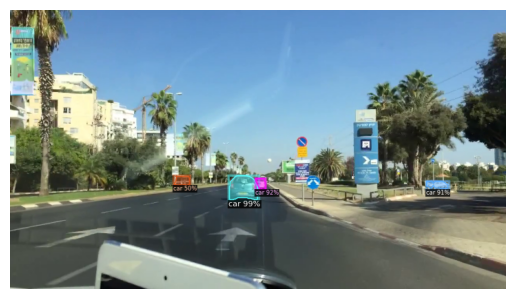

📸 Snapshot from 029abf56-094a6f08.mp4, frame 177


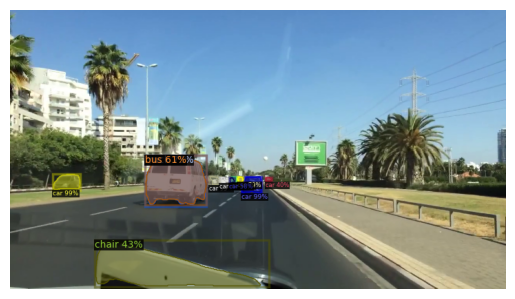

📸 Snapshot from 029abf56-094a6f08.mp4, frame 193


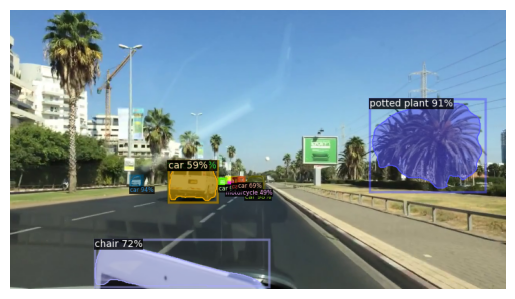

📸 Snapshot from 029abf56-094a6f08.mp4, frame 217


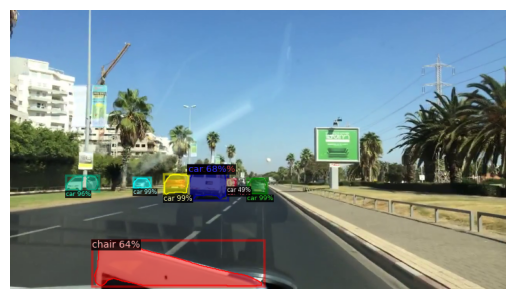

📸 Snapshot from 029abf56-094a6f08.mp4, frame 245


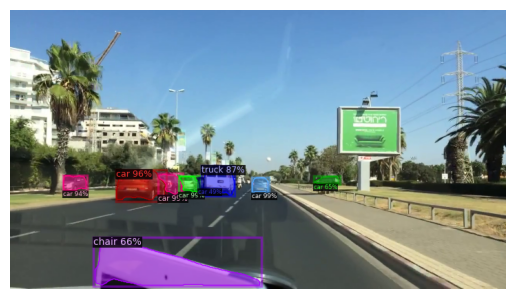

📸 Snapshot from 029abf56-094a6f08.mp4, frame 314


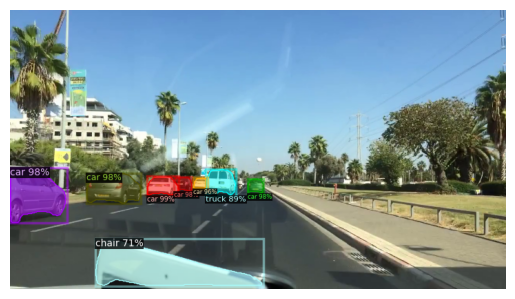

📸 Snapshot from 029abf56-094a6f08.mp4, frame 334


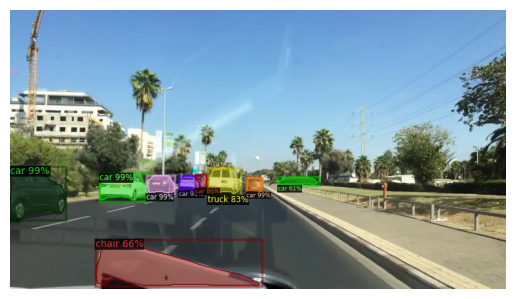

📸 Snapshot from 029abf56-094a6f08.mp4, frame 382


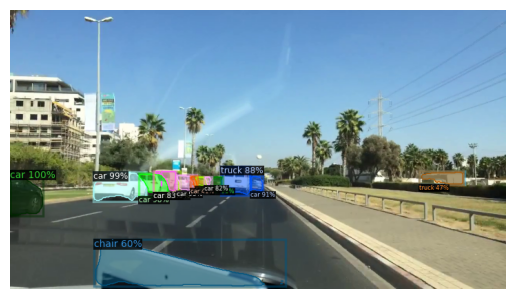

📸 Snapshot from 029abf56-094a6f08.mp4, frame 398


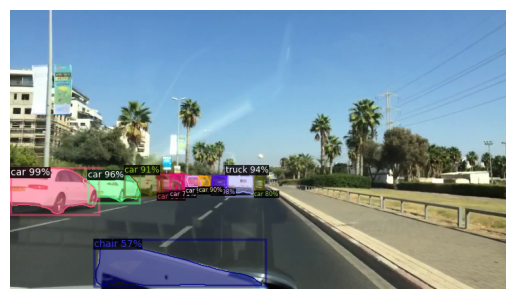

📸 Snapshot from 029abf56-094a6f08.mp4, frame 422


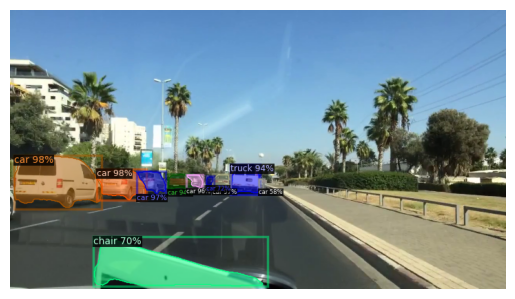

📸 Snapshot from 029abf56-094a6f08.mp4, frame 668


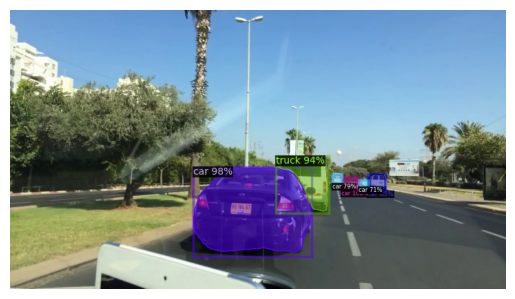

📸 Snapshot from 029abf56-094a6f08.mp4, frame 728


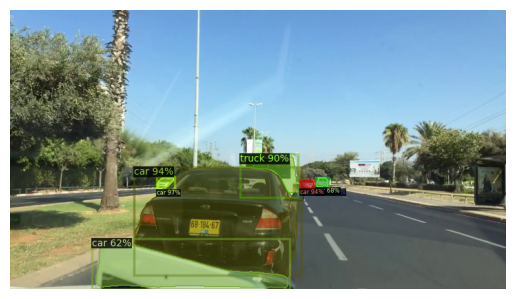

📸 Snapshot from 029abf56-094a6f08.mp4, frame 873


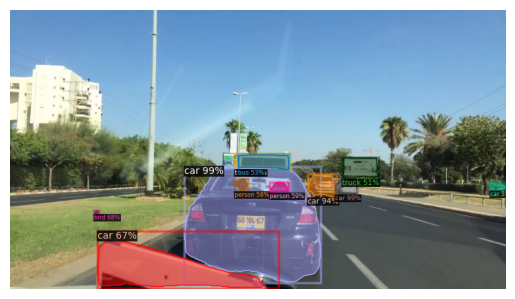

📸 Snapshot from 029abf56-094a6f08.mp4, frame 889


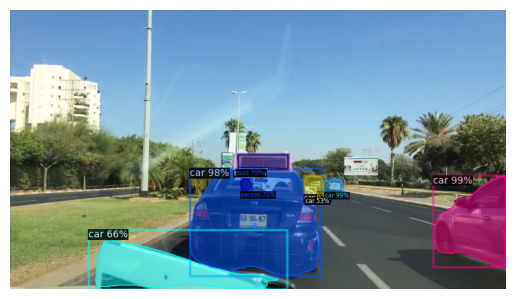

📸 Snapshot from 029abf56-094a6f08.mp4, frame 897


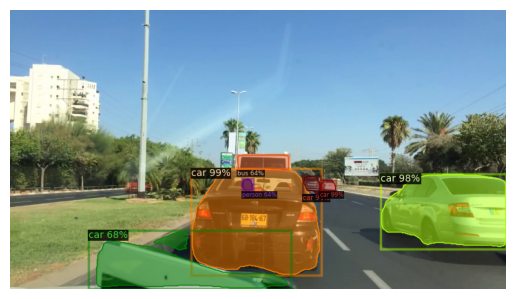

In [ ]:
#Visualize a few randomly selected annotated frames
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

#Helper function to display frames using matplotlib
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

#Loop through collected snapshot frames and display them with predicted masks
for i, (frame, inst, vid, idx) in enumerate(snapshot_frames):
    v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
    out = v.draw_instance_predictions(inst)
    print(f"📸 Snapshot from {vid}, frame {idx}")
    show_img(out.get_image()[:, :, ::-1])